# Load required libraries

In [76]:
import pandas as pd
import numpy as np
import boto3
import sagemaker

sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

# Download the datasets from private S3 bucket

In [77]:
!aws s3 cp 's3://sagemaker-studio-111803057601-stq1w2z0tjr/df_psych.csv' ./data/

download: s3://sagemaker-studio-111803057601-stq1w2z0tjr/df_psych.csv to data/df_psych.csv


In [78]:
import csv

df_psych = pd.read_csv(
    "./data/df_psych.csv",
    delimiter=",",
    quoting=csv.QUOTE_NONE,
)
df_psych = df_psych.iloc[:,1:]
df_psych.head(100)

,user_id,platform_x,level_1,level_2,level_3,confidence_score,country_code,asset_id,minutes_viewed,showtype,genre,running_minutes,source_language,season_id,series_id,studio_id,minutes_under_2
0,8.589935e+10,web-embed,Psychographics,Movies Lovers,Horror Movies Fans,0.07,ID,10377,1,Movies,Horror,87,Indonesian,NaN,NaN,350.0,True
1,8.589935e+10,web-embed,Psychographics,Movies Lovers,Indonesian Movies Fans,0.03,ID,10377,1,Movies,Horror,87,Indonesian,NaN,NaN,350.0,True
2,2.576980e+10,android,Psychographics,Movies Lovers,Romance Movies Fans,0.52,ID,10377,3,Movies,Horror,87,Indonesian,NaN,NaN,350.0,False
3,2.576980e+10,android,Psychographics,TV Lovers,Kids TV Fans,0.61,ID,10377,3,Movies,Horror,87,Indonesian,NaN,NaN,350.0,False
4,2.576980e+10,android,Psychographics,TV Lovers,Drama TV Fans,0.60,ID,10377,3,Movies,Horror,87,Indonesian,NaN,NaN,350.0,False
5,2.576980e+10,android,Psychographics,TV Lovers,English TV Fans,0.45,ID,10377,3,Movies,Horror,87,Indonesian,NaN,NaN,350.0,False
6,2.576980e+10,android,Psychographics,TV Lovers,Sports TV Fans,0.03,ID,10377,3,Movies,Horror,87,Indonesian,NaN,NaN,350.0,False
7,2.576980e+10,android,Psychographics,TV Lovers,Malay TV Fans,0.17,ID,10377,3,Movies,Horror,87,Indonesian,NaN,NaN,350.0,False
8,2.576980e+10,android,Psychographics,Movies Lovers,English Movies Fans,0.85,ID,10377,3,Movies,Horror,87,Indonesian,NaN,NaN,350.0,False
9,2.576980e+10,android,Psychographics,Mobile Enthusiasts,High Data Users,0.82,ID,10377,3,Movies,Horror,87,Indonesian,NaN,NaN,350.0,False


# Clean up missing values and outliers

## Missing values first

Recall that we have some missing values in the dataset

In [79]:
df_psych.isnull().sum()

user_id                  0
platform_x               0
level_1                  0
level_2                  0
level_3               4850
confidence_score         0
country_code             0
asset_id                 0
minutes_viewed           0
showtype                 0
genre                    5
running_minutes          0
source_language        701
season_id           146311
series_id           146311
studio_id              300
minutes_under_2          0
dtype: int64

It occurs to us that some records don't have genres so we remove those specific records.

In [80]:
df_psych = df_psych.dropna(subset=['genre'])
df_psych.isnull().sum()
print('\n')

We are going to see which studios are missing the source language.

In [81]:
df1 = df_psych[['studio_id','source_language']]
df2 = df1.loc[df1['source_language'].isna()]
print(df2['studio_id'].unique())

[229. 321.  10. 301.  79. 442. 373.  73. 127. 390.  69. 226. 170. 111.
 241. 447.]


In [82]:
df1[df1['studio_id'].isin([229., 321.,  10., 301.,  79., 442., 373.,  73., 127., 390.,  69.,
       226., 170., 111., 241., 447.])].groupby('studio_id')['source_language'].nunique()

studio_id
10.0     2
69.0     1
73.0     0
79.0     0
111.0    0
127.0    1
170.0    1
226.0    2
229.0    1
241.0    0
301.0    0
321.0    0
373.0    0
390.0    1
442.0    0
447.0    1
Name: source_language, dtype: int64

For the studios that are missing source language, there can be no language, one language or two languages. To avoid confusion, we will remove records with missing studio_id and source_language.

In [83]:
df_psych = df_psych.dropna(subset=['studio_id','source_language'])
df_psych.isnull().sum()

user_id                  0
platform_x               0
level_1                  0
level_2                  0
level_3               4839
confidence_score         0
country_code             0
asset_id                 0
minutes_viewed           0
showtype                 0
genre                    0
running_minutes          0
source_language          0
season_id           145653
series_id           145653
studio_id                0
minutes_under_2          0
dtype: int64

We can see that season_id and series_id have an equal amount of records and recall the showtype in the dataset has only 2 types.

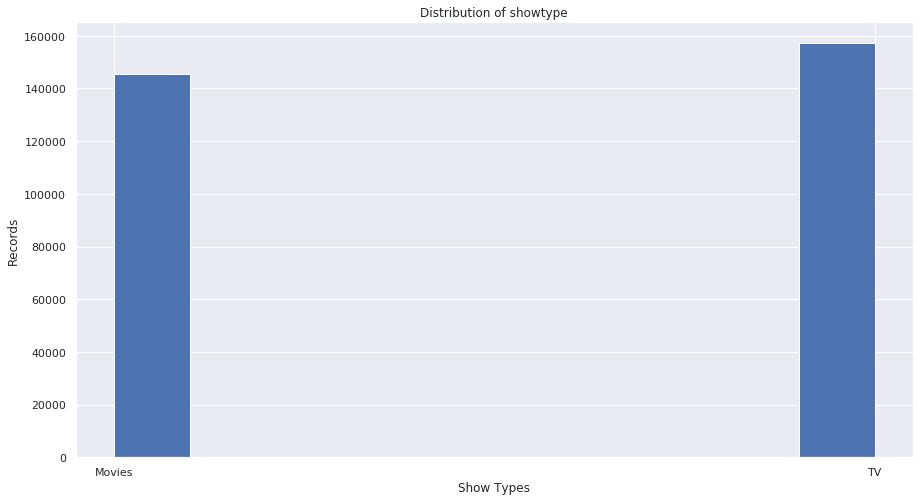

In [84]:
import matplotlib.pyplot as plt

plt.hist(df_psych['showtype'])
plt.xlabel("Show Types")
plt.ylabel("Records")
plt.title("Distribution of showtype")
plt.show()

In [85]:
df1 = df_psych[['showtype','season_id',"series_id"]]
df2 = df1.loc[(df1['season_id'].isna()) & (df1['series_id'].isna())]

In [86]:
df2.groupby('showtype')['season_id'].nunique()

showtype
Movies    1
Name: season_id, dtype: int64

In [87]:
df2.groupby('showtype')['series_id'].nunique()

showtype
Movies    1
Name: series_id, dtype: int64

This means that as long as we have valid season_id and series_id, the showtype must be TV shows while those values would be nulls for Movies.
Therefore, there is no need to keep season_id and series_id since they are directly correlated to showtype. So we remove the two columns.

In [88]:
df_psych = df_psych.drop(['season_id', 'series_id'], axis=1)
df_psych.isnull().sum()

user_id                0
platform_x             0
level_1                0
level_2                0
level_3             4839
confidence_score       0
country_code           0
asset_id               0
minutes_viewed         0
showtype               0
genre                  0
running_minutes        0
source_language        0
studio_id              0
minutes_under_2        0
dtype: int64

In [89]:
pd.unique(df_psych['level_3'])

array(['Horror Movies Fans', 'Indonesian Movies Fans',
       'Romance Movies Fans', 'Kids TV Fans', 'Drama TV Fans',
       'English TV Fans', 'Sports TV Fans', 'Malay TV Fans',
       'English Movies Fans', 'High Data Users',
       'Extreme Sports Movies Fans', 'Reality TV Fans', 'Comedy TV Fans',
       'Action and Adventure TV Fans', 'Comedy Movies Fans', nan,
       'Action and Adventure Movies Fans', 'Kids Movies Fans',
       'Local Commuters', 'Indonesian TV Fans', 'Thriller Movies Fans',
       'Korean TV Fans', 'Korean Movies Fans', 'Sci-Fi Movies Fans',
       'Drama Movies Fans', 'player', 'Malay Movies Fans',
       'Anime TV Fans', 'Fantasy Movies Fans', 'Family Movies Fans',
       '"""""""\\""""""""\\"""""""""""""""', 'Japanese TV Fans', 'casual',
       'Romance TV Fans', 'Japanese Movies Fans', 'Anime Movies Fans',
       'Chinese Movies Fans', 'Thai Movies Fans', 'Horror TV Fans',
       'Crime and Mystery Movies Fans', 'Hindi Movies Fans',
       'Turkish Movies Fa

Some level_3 traits are not valid, we will find out which level_2 traits those invalid level_3 traits belong to,
and replace the invalid level_3 traits to the same as level_2

In [90]:
pd.unique(df_psych['level_2'])

array(['Movies Lovers', 'TV Lovers', 'Mobile Enthusiasts',
       'News Junkies & Avid Readers', 'Travellers', 'Sports Fans',
       'iflix Viewing Behaviour', 'Social Media Fans', 'Music Lovers'],
      dtype=object)

In [91]:
lev3_null = df_psych.loc[df_psych['level_3'].isnull(), ('level_2')]
pd.unique(lev3_null)

array(['News Junkies & Avid Readers', 'Sports Fans', 'Music Lovers'],
      dtype=object)

In [92]:
# setting level_2 traits to be level_3 traits where level_3 is null.

df_psych.loc[df_psych['level_3'].isnull(),'level_3'] = df_psych['level_2']

df_psych.isnull().sum()


user_id             0
platform_x          0
level_1             0
level_2             0
level_3             0
confidence_score    0
country_code        0
asset_id            0
minutes_viewed      0
showtype            0
genre               0
running_minutes     0
source_language     0
studio_id           0
minutes_under_2     0
dtype: int64

In [93]:
pd.unique(df_psych['level_3'])

array(['Horror Movies Fans', 'Indonesian Movies Fans',
       'Romance Movies Fans', 'Kids TV Fans', 'Drama TV Fans',
       'English TV Fans', 'Sports TV Fans', 'Malay TV Fans',
       'English Movies Fans', 'High Data Users',
       'Extreme Sports Movies Fans', 'Reality TV Fans', 'Comedy TV Fans',
       'Action and Adventure TV Fans', 'Comedy Movies Fans',
       'News Junkies & Avid Readers', 'Action and Adventure Movies Fans',
       'Kids Movies Fans', 'Local Commuters', 'Indonesian TV Fans',
       'Thriller Movies Fans', 'Korean TV Fans', 'Korean Movies Fans',
       'Sports Fans', 'Sci-Fi Movies Fans', 'Drama Movies Fans', 'player',
       'Malay Movies Fans', 'Anime TV Fans', 'Fantasy Movies Fans',
       'Family Movies Fans', '"""""""\\""""""""\\"""""""""""""""',
       'Music Lovers', 'Japanese TV Fans', 'casual', 'Romance TV Fans',
       'Japanese Movies Fans', 'Anime Movies Fans', 'Chinese Movies Fans',
       'Thai Movies Fans', 'Horror TV Fans',
       'Crime and Myst

## Now consider outliers..

In [94]:
df_psych.describe()

,user_id,confidence_score,asset_id,minutes_viewed,running_minutes,studio_id
count,3.028420e+05,302842.000000,302842.000000,302842.000000,302842.000000,302842.000000
mean,4.797900e+10,0.627068,9453.736298,36.844579,73.117348,260.981069
std,2.993233e+10,0.317694,5083.632755,63.522916,34.014620,129.269095
min,1.000000e+00,0.000000,6.000000,0.000000,6.000000,3.000000
25%,2.576980e+10,0.330000,5274.000000,2.000000,47.000000,215.000000
50%,5.153961e+10,0.690000,9239.000000,19.000000,69.500000,265.000000
75%,7.730941e+10,0.930000,14309.000000,62.000000,97.000000,371.000000
max,9.448928e+10,1.000000,17269.000000,5482.000000,211.000000,459.000000


Recall that we have plenty outilers in running_minutes and minutes_viewed

In [95]:
# Use a z-score of 3 as the cutoff

from scipy import stats


df_psych = df_psych[(np.abs(stats.zscore(df_psych['minutes_viewed']))< 3)]
df_psych = df_psych[(np.abs(stats.zscore(df_psych['running_minutes']))< 3)]

Text(0, 0.5, 'minutes_viewed')

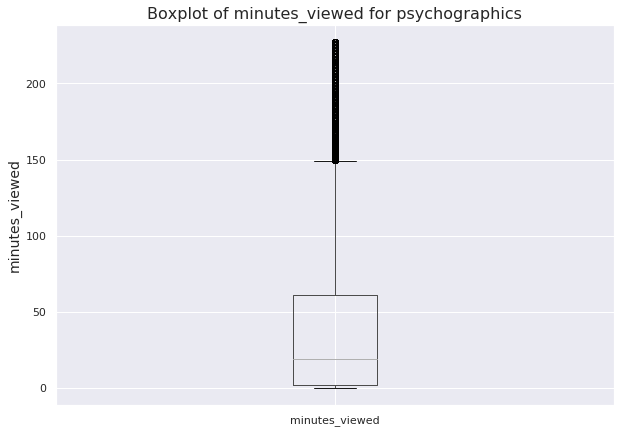

In [96]:
# Use boxplot to check for outliers in minutes_viewed
import matplotlib.pyplot as plt

fig = plt.figure(figsize =(10, 7))
boxplot = df_psych.boxplot(column=['minutes_viewed'])
plt.title("Boxplot of minutes_viewed for psychographics", fontsize = 16)
plt.ylabel("minutes_viewed", fontsize= 14 )

Text(0, 0.5, 'running_minutes')

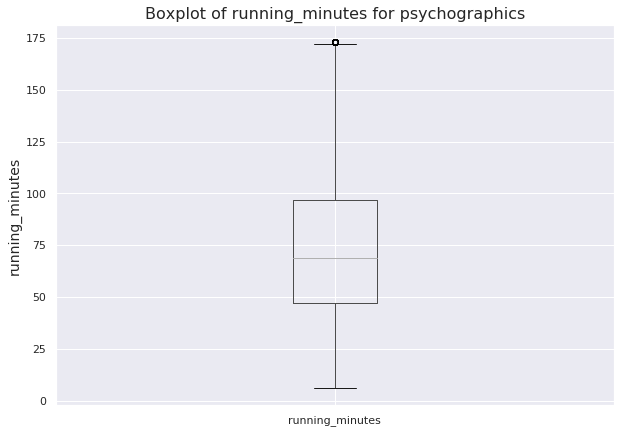

In [97]:
# Use boxplot to check for outliers in running_minutes

fig = plt.figure(figsize =(10, 7))
boxplot = df_psych.boxplot(column=['running_minutes'])
plt.title("Boxplot of running_minutes for psychographics", fontsize = 16)
plt.ylabel("running_minutes", fontsize= 14 )

# Feature Engineering

## Remove 'iflix Viewing Behaviour' from level_2 traits

In [98]:
df_psych[['level_2']].groupby('level_2').nunique()

,level_2
level_2,
Mobile Enthusiasts,1
Movies Lovers,1
Music Lovers,1
News Junkies & Avid Readers,1
Social Media Fans,1
Sports Fans,1
TV Lovers,1
Travellers,1
iflix Viewing Behaviour,1


Since "iflix Viewing Behaviour" doesn't fit into the rest of the traits, we will remove the records with it.

In [99]:
df_psych = df_psych[df_psych.level_2 != 'iflix Viewing Behaviour']
df_psych[['level_2']].groupby('level_2').nunique()

,level_2
level_2,
Mobile Enthusiasts,1
Movies Lovers,1
Music Lovers,1
News Junkies & Avid Readers,1
Social Media Fans,1
Sports Fans,1
TV Lovers,1
Travellers,1


## Feature Engineering

In [100]:
# viewing unique categories in these features - language, genre, and platform

pd.unique(df_psych['source_language'])

array(['Indonesian', 'English', 'Chinese', 'Malay', 'Nepali', 'Korean',
       'Tagalog', 'Japanese', 'Burmese', 'Kanuri', 'Thai', 'Hindi',
       'Tamil', 'Bengali', 'Vietnamese', 'Swahili', 'Central Khmer',
       'Portuguese', 'Urdu', 'Hungarian', 'Spanish; Castilian', 'French',
       'Italian', 'Turkish', 'Tajik', 'Swedish', 'Norwegian', 'Arabic',
       'Danish', 'Sinhala; Sinhalese', 'Afrikaans', 'Avaric'],
      dtype=object)

In [101]:
pd.unique(df_psych['genre'])

array(['Horror', 'Comedy', 'Drama', 'Thriller', 'Romance',
       'Action and Adventure', 'Others', 'Kids',
       'Documentary and Biography', 'Anime', 'Fantasy', 'Music',
       'Crime and Mystery', 'Sci-Fi', 'Reality', 'Sports',
       'Extreme Sports', 'Lifestyle and Fashion', 'Family', 'Game Show',
       'Best of Web or Viral', 'Animation', 'Education', 'eSports',
       'Adult Romance', 'News', 'Religion and Faith',
       'Health and Fitness', 'Live Events and Specials'], dtype=object)

In [102]:
pd.unique(df_psych['platform_x'])

array(['web-embed', 'android', 'iOS', 'android-tv', 'webOS', 'web',
       'Panasonic', 'web-pwa', 'Roku', 'Samsung Tizen', 'googlecast',
       'Vewd', 'Samsung Orsay'], dtype=object)

There's an opportunity to simplify the platform column

In [103]:
# Combine platforms into a more generalized group
# writing function platform_type

def platform_type (row):
    if row['platform_x'] in ('android','iOS'):
        return 'mobile_phone'
    if row['platform_x'] in ('web-embed', 'webOS', 'web', 'web-pwa'):
        return 'web_based'
    if row['platform_x'] in ('android-tv', 'Panasonic', 'Roku', 'Samsung Tizen', 'googlecast', 'Vewd', 'Samsung Orsay'):
        return 'home_tv'
    return row['platform_x']

In [104]:
# applying function to our dataframe, creating a new column 'platform_type' for this

df_psych['platform_type'] = df_psych.apply(lambda row: platform_type(row), axis=1)

In [105]:
# creating a feature for how much of an asset a given user watched in a session as a percentage

df_psych['pct_watched'] = round((df_psych['minutes_viewed'] / df_psych['running_minutes']) * 100, 2)

df_psych.head()

,user_id,platform_x,level_1,level_2,level_3,confidence_score,country_code,asset_id,minutes_viewed,showtype,genre,running_minutes,source_language,studio_id,minutes_under_2,platform_type,pct_watched
0,8.589935e+10,web-embed,Psychographics,Movies Lovers,Horror Movies Fans,0.07,ID,10377,1,Movies,Horror,87,Indonesian,350.0,True,web_based,1.15
1,8.589935e+10,web-embed,Psychographics,Movies Lovers,Indonesian Movies Fans,0.03,ID,10377,1,Movies,Horror,87,Indonesian,350.0,True,web_based,1.15
2,2.576980e+10,android,Psychographics,Movies Lovers,Romance Movies Fans,0.52,ID,10377,3,Movies,Horror,87,Indonesian,350.0,False,mobile_phone,3.45
3,2.576980e+10,android,Psychographics,TV Lovers,Kids TV Fans,0.61,ID,10377,3,Movies,Horror,87,Indonesian,350.0,False,mobile_phone,3.45
4,2.576980e+10,android,Psychographics,TV Lovers,Drama TV Fans,0.60,ID,10377,3,Movies,Horror,87,Indonesian,350.0,False,mobile_phone,3.45


In [106]:
df_psych['pct_watched'].describe()

count    279458.000000
mean         52.579142
std          53.331299
min           0.000000
25%           2.780000
50%          37.655000
75%          98.350000
max         821.430000
Name: pct_watched, dtype: float64

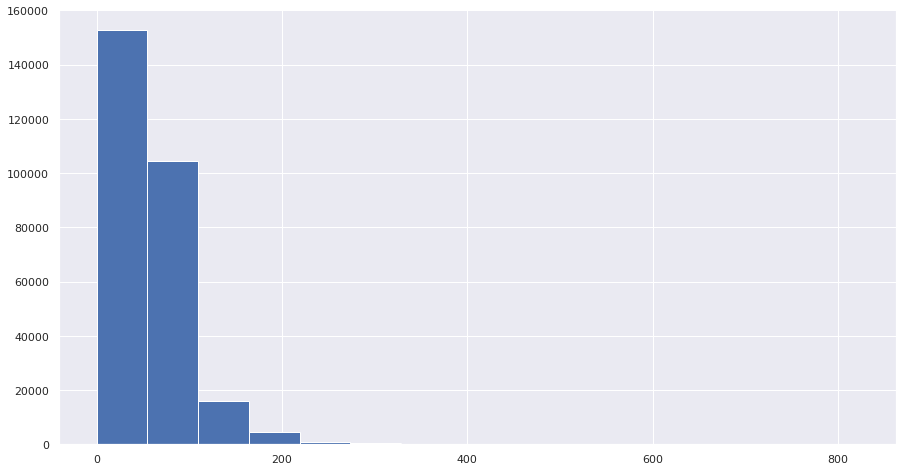

In [107]:
plt.hist(df_psych['pct_watched'], bins = 15)
plt.show()

In [108]:
# get rid of outliers in new pct_watched column

df_psych = df_psych[(np.abs(stats.zscore(df_psych['pct_watched']))< 3)]

In [109]:
df_psych.pct_watched.describe()

count    277588.000000
mean         50.895976
std          48.609306
min           0.000000
25%           2.700000
50%          36.460000
75%          98.200000
max         212.500000
Name: pct_watched, dtype: float64

AttributeError: module 'seaborn' has no attribute 'histplot'

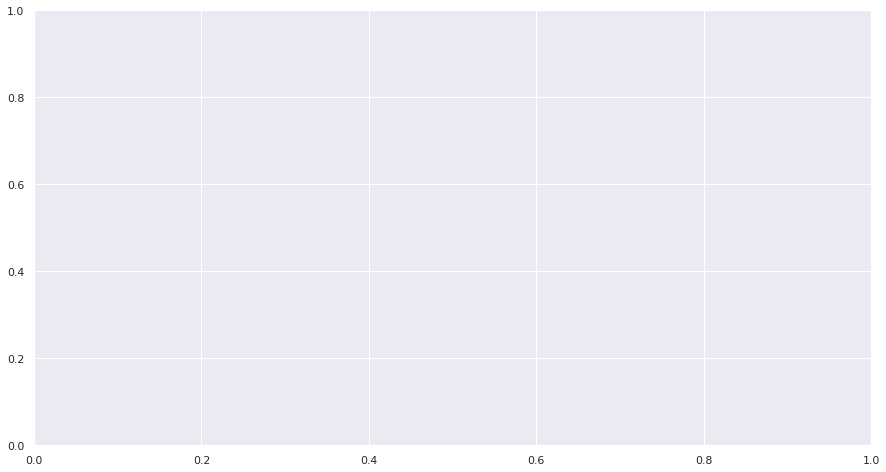

In [110]:
import seaborn as sns

fig, ax = plt.subplots()
sns.histplot(data = df_psych, x = 'pct_watched', bins = 20, ax=ax)
ax.set_xticks(range(0,240,20))

In [111]:
# creating buckets for percentages watched. will make it, roughly, based on quartiles

df_psych['0-10'] = [1 if x <=10 else 0 for x in df_psych['pct_watched']]

df_psych['11-90'] = [1 if 10 < x <= 90 else 0 for x in df_psych['pct_watched']]

df_psych['90-100'] = [1 if 90 < x <= 100 else 0 for x in df_psych['pct_watched']]

df_psych['>100'] = [1 if x > 100 else 0 for x in df_psych['pct_watched']]

## Remove features that don't contribute to training models

In [112]:
df_psych = df_psych.drop(['user_id','level_1','level_3','asset_id','studio_id','minutes_under_2','platform_x'],axis = 1)
df_psych.head()

,level_2,confidence_score,country_code,minutes_viewed,showtype,genre,running_minutes,source_language,platform_type,pct_watched,0-10,11-90,90-100,>100
0,Movies Lovers,0.07,ID,1,Movies,Horror,87,Indonesian,web_based,1.15,1,0,0,0
1,Movies Lovers,0.03,ID,1,Movies,Horror,87,Indonesian,web_based,1.15,1,0,0,0
2,Movies Lovers,0.52,ID,3,Movies,Horror,87,Indonesian,mobile_phone,3.45,1,0,0,0
3,TV Lovers,0.61,ID,3,Movies,Horror,87,Indonesian,mobile_phone,3.45,1,0,0,0
4,TV Lovers,0.60,ID,3,Movies,Horror,87,Indonesian,mobile_phone,3.45,1,0,0,0


## Check Correlations between all independent variables

In [113]:
df = df_psych.drop(['level_2','confidence_score'],axis = 1)

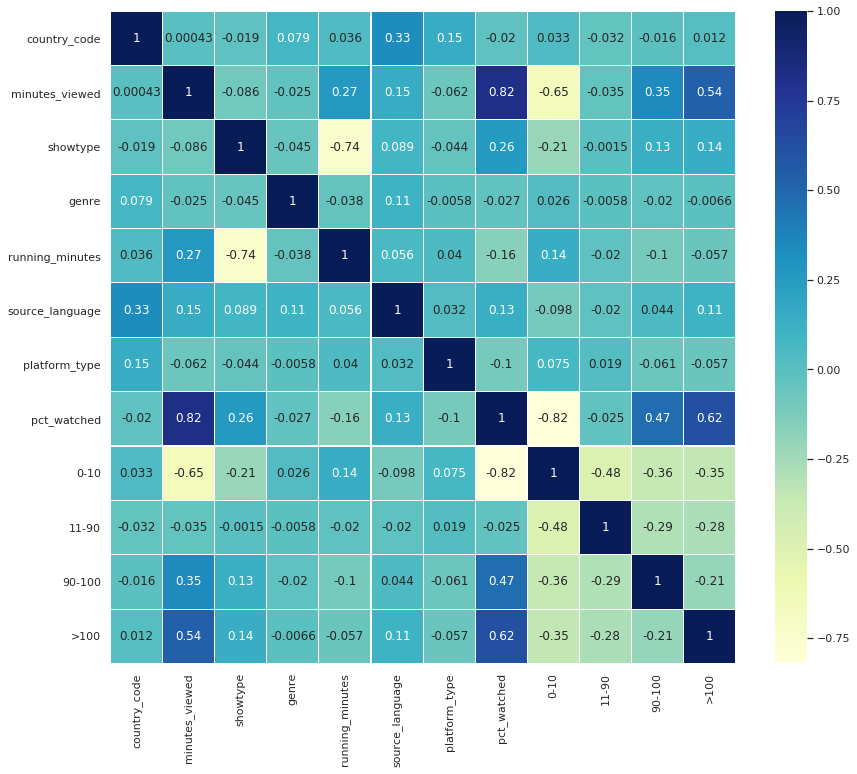

In [114]:
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

labelencoder=LabelEncoder()
for column in df.columns:
    df[column] = labelencoder.fit_transform(df[column])
    
    
plt.figure(figsize=(14,12))
sns.heatmap(df.corr(),linewidths=.1,cmap="YlGnBu", annot=True)
plt.yticks(rotation=0);

Removing running_minutes from the dataframe due to high correlation with showtype; ALSO removing pct_watched now as we have our data bucketed, and also the final bucket of >100 as it is implied if 0 in the other 3. which we can recall from this:

In [ ]:
# sns.histplot(data=df_psych,x='running_minutes', hue = 'showtype', bins = 30)

running_minutes is almost directly related to the showtype.

In [115]:
df_psych = df_psych.drop(['running_minutes', 'pct_watched','>100'],axis = 1)
df_psych.head()

,level_2,confidence_score,country_code,minutes_viewed,showtype,genre,source_language,platform_type,0-10,11-90,90-100
0,Movies Lovers,0.07,ID,1,Movies,Horror,Indonesian,web_based,1,0,0
1,Movies Lovers,0.03,ID,1,Movies,Horror,Indonesian,web_based,1,0,0
2,Movies Lovers,0.52,ID,3,Movies,Horror,Indonesian,mobile_phone,1,0,0
3,TV Lovers,0.61,ID,3,Movies,Horror,Indonesian,mobile_phone,1,0,0
4,TV Lovers,0.60,ID,3,Movies,Horror,Indonesian,mobile_phone,1,0,0


Before balancing the data, we need to look at the confidence score from the original dataset:

In [116]:
df_psych['confidence_score'].describe()

count    277588.000000
mean          0.596906
std           0.311420
min           0.000000
25%           0.300000
50%           0.650000
75%           0.890000
max           1.000000
Name: confidence_score, dtype: float64

In [117]:
print('50th percentile: ', df_psych['confidence_score'].quantile(.5))
print('60th percentile: ', df_psych['confidence_score'].quantile(.6))
print('70th percentile: ', df_psych['confidence_score'].quantile(.7))
print('80th percentile: ', df_psych['confidence_score'].quantile(.8))
print('90th percentile: ', df_psych['confidence_score'].quantile(.9))
print('95th percentile: ', df_psych['confidence_score'].quantile(.95))

50th percentile:  0.65
60th percentile:  0.76
70th percentile:  0.86
80th percentile:  0.92
90th percentile:  0.98
95th percentile:  1.0


We want to ensure data quality and pick our record within 70th percentile

In [118]:
q7 = df_psych['confidence_score'].quantile(.7)

df_psych = df_psych.loc[df_psych['confidence_score'] > q7]
df_psych['confidence_score'].describe()

count    79464.000000
mean         0.949769
std          0.043060
min          0.870000
25%          0.910000
50%          0.960000
75%          0.990000
max          1.000000
Name: confidence_score, dtype: float64

We remove confidence_score from the dataset

In [119]:
df_psych = df_psych.drop(['confidence_score'], axis = 1)

## Encoding categorical data

In [120]:
df_psych.dtypes

level_2            object
country_code       object
minutes_viewed      int64
showtype           object
genre              object
source_language    object
platform_type      object
0-10                int64
11-90               int64
90-100              int64
dtype: object

In [121]:
# encoding showtype

df_psych = pd.get_dummies(df_psych,prefix=['showtype'], columns = ['showtype'], drop_first=True)

df_psych.head()

,level_2,country_code,minutes_viewed,genre,source_language,platform_type,0-10,11-90,90-100,showtype_TV
26,Movies Lovers,ID,3,Horror,Indonesian,mobile_phone,1,0,0,0
37,Mobile Enthusiasts,ID,1,Horror,Indonesian,mobile_phone,1,0,0,0
40,Movies Lovers,ID,1,Horror,Indonesian,mobile_phone,1,0,0,0
44,Movies Lovers,ID,75,Horror,Indonesian,mobile_phone,0,1,0,0
45,Movies Lovers,ID,75,Horror,Indonesian,mobile_phone,0,1,0,0


In [122]:
# encoding genre
df_psych = pd.get_dummies(df_psych,prefix=['genre'], columns = ['genre'], drop_first=True)
df_psych.head()

,level_2,country_code,minutes_viewed,source_language,platform_type,0-10,11-90,90-100,showtype_TV,genre_Adult Romance,...,genre_Music,genre_News,genre_Others,genre_Reality,genre_Religion and Faith,genre_Romance,genre_Sci-Fi,genre_Sports,genre_Thriller,genre_eSports
26,Movies Lovers,ID,3,Indonesian,mobile_phone,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
37,Mobile Enthusiasts,ID,1,Indonesian,mobile_phone,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40,Movies Lovers,ID,1,Indonesian,mobile_phone,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44,Movies Lovers,ID,75,Indonesian,mobile_phone,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
45,Movies Lovers,ID,75,Indonesian,mobile_phone,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [123]:
# encoding country_code
df_psych = pd.get_dummies(df_psych,prefix=['country_code'], columns = ['country_code'], drop_first=True)
df_psych.head()

,level_2,minutes_viewed,source_language,platform_type,0-10,11-90,90-100,showtype_TV,genre_Adult Romance,genre_Animation,...,country_code_LK,country_code_MM,country_code_MY,country_code_NP,country_code_PH,country_code_PK,country_code_SD,country_code_TH,country_code_VN,country_code_ZW
26,Movies Lovers,3,Indonesian,mobile_phone,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
37,Mobile Enthusiasts,1,Indonesian,mobile_phone,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40,Movies Lovers,1,Indonesian,mobile_phone,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44,Movies Lovers,75,Indonesian,mobile_phone,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
45,Movies Lovers,75,Indonesian,mobile_phone,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [124]:
# encoding language
df_psych = pd.get_dummies(df_psych,prefix=['source_language'], columns = ['source_language'], drop_first=True)
df_psych.head()

,level_2,minutes_viewed,platform_type,0-10,11-90,90-100,showtype_TV,genre_Adult Romance,genre_Animation,genre_Anime,...,source_language_Portuguese,source_language_Spanish; Castilian,source_language_Swahili,source_language_Tagalog,source_language_Tajik,source_language_Tamil,source_language_Thai,source_language_Turkish,source_language_Urdu,source_language_Vietnamese
26,Movies Lovers,3,mobile_phone,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
37,Mobile Enthusiasts,1,mobile_phone,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40,Movies Lovers,1,mobile_phone,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44,Movies Lovers,75,mobile_phone,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
45,Movies Lovers,75,mobile_phone,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [125]:
# encoding platform_type
df_psych = pd.get_dummies(df_psych,prefix=['platform_type'], columns = ['platform_type'], drop_first=True)
df_psych.head()

,level_2,minutes_viewed,0-10,11-90,90-100,showtype_TV,genre_Adult Romance,genre_Animation,genre_Anime,genre_Comedy,...,source_language_Swahili,source_language_Tagalog,source_language_Tajik,source_language_Tamil,source_language_Thai,source_language_Turkish,source_language_Urdu,source_language_Vietnamese,platform_type_mobile_phone,platform_type_web_based
26,Movies Lovers,3,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
37,Mobile Enthusiasts,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
40,Movies Lovers,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
44,Movies Lovers,75,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
45,Movies Lovers,75,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


## Encoding the level_2 traits

In [136]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df_psych['level_2'] = label_encoder.fit_transform(df_psych['level_2'])
df_psych.head()

,level_2,minutes_viewed,0-10,11-90,90-100,showtype_TV,genre_Adult Romance,genre_Animation,genre_Anime,genre_Comedy,...,source_language_Swahili,source_language_Tagalog,source_language_Tajik,source_language_Tamil,source_language_Thai,source_language_Turkish,source_language_Urdu,source_language_Vietnamese,platform_type_mobile_phone,platform_type_web_based
26,1,3,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
37,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
40,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
44,1,75,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
45,1,75,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


# Balance The Data

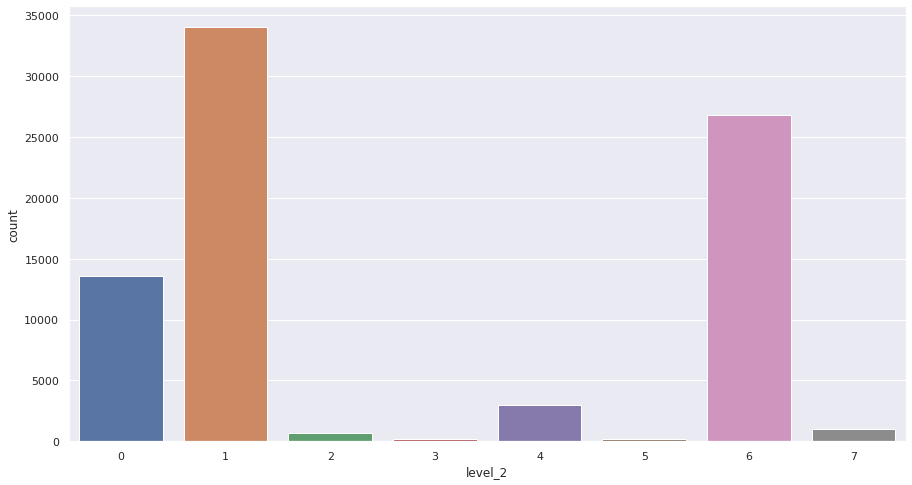

In [137]:
sns.set(rc={'figure.figsize':(15,8)})

sns.countplot(data=df_psych, x='level_2')

We can see that the target variable (level_2 trait) has a very uneven distribution the majority of its categories.

In [138]:
pd.set_option("display.max_rows", None)
df_psych['level_2'].value_counts()

1    34036
6    26835
0    13580
4     2996
7      990
2      711
5      163
3      153
Name: level_2, dtype: int64

Checking what the "baseline accuracy" would be for this model

In [140]:
baseline = (df_psych['level_2'].value_counts()[1] / df_psych.shape[0]) * 100

baseline

42.831974227323066

Movies Lovers is the number 1 category - roughly 41.89 % of the data is comprised of movie lovers, thus, the baseline accuracy of the model is 42.75%.

In [141]:
# going to balance data set using oversampling to ensure we have data for 

df_grouped_by = df_psych.groupby(["level_2"])
df_balanced = df_grouped_by.apply(
lambda x: x.sample(df_grouped_by.size().max(),replace=True)\
.reset_index(drop=True)
)

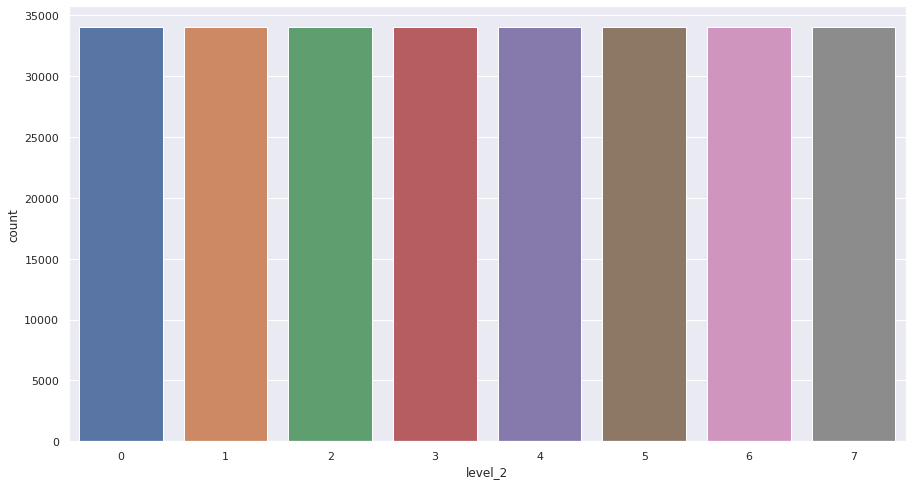

In [142]:
sns.set(rc={'figure.figsize':(15,8)})

sns.countplot(data=df_balanced, x='level_2')

In [143]:
df_balanced['level_2'].value_counts()

7    34036
6    34036
5    34036
4    34036
3    34036
2    34036
1    34036
0    34036
Name: level_2, dtype: int64

# Split the data into train, validate and test

In [154]:
# Split the data as: train - 90%, validate - 5%, test - 5%

from sklearn.model_selection import train_test_split

# Split all data into 70% train and 30% holdout
df_train, df_holdout = train_test_split(df_balanced, test_size=0.10, stratify=df_balanced['level_2'])

# Split holdout data into 50% validation and 50% test
df_validation, df_test = train_test_split(df_holdout, test_size=0.50, stratify=df_holdout['level_2'])

In [155]:
df_train.shape

(245059, 80)

In [156]:
df_train.head()

,,level_2,minutes_viewed,0-10,11-90,90-100,showtype_TV,genre_Adult Romance,genre_Animation,genre_Anime,genre_Comedy,...,source_language_Swahili,source_language_Tagalog,source_language_Tajik,source_language_Tamil,source_language_Thai,source_language_Turkish,source_language_Urdu,source_language_Vietnamese,platform_type_mobile_phone,platform_type_web_based
level_2,,,,,,,,,,,,,,,,,,,,,,
5,16429,5,0,1,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,3938,4,2,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,9749,5,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,9235,1,86,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
0,939,0,5,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [157]:
df_validation.shape


(13614, 80)

In [158]:
df_test.shape

(13615, 80)

In [150]:
df_train.index.value_counts

<bound method IndexOpsMixin.value_counts of MultiIndex([(6, 26741),
            (2,  1480),
            (1, 28169),
            (0, 33528),
            (6, 31433),
            (0, 25744),
            (0, 28832),
            (7, 18610),
            (2,  8848),
            (5,  9324),
            ...
            (5, 21546),
            (7, 31773),
            (6, 26661),
            (2, 22811),
            (7, 26786),
            (7, 17761),
            (1, 13063),
            (7,    82),
            (3, 19183),
            (2, 10881)],
           names=['level_2', None], length=245059)>

In [152]:
df_train.shape

(245059, 79)

# Save these files to S3 bucket

In [ ]:
# Create a new s3 bucket
!aws s3 mb s3://ads508-team4-split

In [159]:
# Store these 3 files

from io import StringIO

bucket = 'ads508-kuc2'
csv_buffer1 = StringIO()
csv_buffer2 = StringIO()
csv_buffer3 = StringIO()

df_train.to_csv(csv_buffer1, header= None, index = None)
df_validation.to_csv(csv_buffer2, header= None, index = None)
df_test.to_csv(csv_buffer3, header= None, index = None)

s3_resource = boto3.resource('s3')
s3_resource.Object(bucket, 'df_train.csv').put(Body=csv_buffer1.getvalue())
s3_resource.Object(bucket, 'df_validation.csv').put(Body=csv_buffer2.getvalue())
s3_resource.Object(bucket, 'df_test.csv').put(Body=csv_buffer3.getvalue())

{'ResponseMetadata': {'RequestId': 'KY7AK37RF554TJ7K',
  'HostId': 'dOi3o+0pICUoumMnc2WxKrKm+f53hnhpHWV3tD9Bdxh7G6xnD4XUNWYEj9+yMSV5wEcrj4V8es4=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'dOi3o+0pICUoumMnc2WxKrKm+f53hnhpHWV3tD9Bdxh7G6xnD4XUNWYEj9+yMSV5wEcrj4V8es4=',
   'x-amz-request-id': 'KY7AK37RF554TJ7K',
   'date': 'Fri, 01 Apr 2022 22:46:51 GMT',
   'etag': '"c2aa16f674048648c796be68f76234b1"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"c2aa16f674048648c796be68f76234b1"'}

In [ ]:
df_train.head(10
             )